<a href="https://colab.research.google.com/github/GiuliaCN/MAC0417/blob/main/ep3_classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EP3.2 - MAC0417/5768 - Visão e Processamento de Imagens

Professor: Roberto Marcondes

Alunos:

*   Carlos Reis NºUSP 11295741
*   Daniel Silva Lopes da Costa N°USP 11302720
*   Giulia Cunha De Nardi N°10692203

Pasta no Drive: https://drive.google.com/drive/folders/1UCvz5sp8_lax59cgArrOyZSArcTVpvfI?usp=sharing


Github: https://github.com/GiuliaCN/MAC0417




# 1 - Introdução

Um algoritmo de classificação supervisionada tem o intuito de prever a qual classe um objeto pertence, para isso, se utiliza uma parte da base de dados segmentada e etiquetada com a sua devida classe para o treino do algoritmo. Para testar os resultados, usa-se o resto do dataset, que não foi utilizado no treino, nele coletamos as métricas necessárias.

# 2 - Objetivo

Realizar a classificação das classes utilizando um algoritmo SVC nos datasets segmentados e analisar os resultados.

# 3 - Leitura dos dados

In [ ]:
# Conectar-se ao Drive
from google.colab import drive

# https://docs.python.org/3/library/os.html
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import numpy as np


# skimage.io para carregar as imagens
# https://scikit-image.org/docs/dev/api/skimage.io.html
from skimage import io
from skimage import data, img_as_float
from skimage import exposure
from skimage.filters import threshold_otsu
from skimage.util import invert

# Biblioteca skimage
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.filters import gaussian
from skimage.feature import canny
from skimage.morphology import binary_dilation
from skimage.util import invert
from skimage import transform
from skimage.util import crop

# bibliotecas do treino
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from skimage.segmentation import clear_border
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# https://pandas.pydata.org/
import pandas as pd

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
os.chdir('/content/gdrive/My Drive/eps/')

In [ ]:
classes = os.listdir('datasets/originalGrayDataset')
classes

['tesoura',
 'copo',
 'chave',
 'escova',
 'desodorante',
 'garfo',
 'faca',
 'grampeador',
 'lapis',
 'oculos']

In [ ]:
def get_base_and_labels_manual():
  base = []
  labels = []
  i = 0
  for classe in classes:
    imgs = io.imread_collection("datasets/segmentedManualDataset/"+classe+"/*.jpg")
    for img in imgs:
      base.append(img)
      labels.append(i)
    i += 1
  return base, labels

def get_base_and_labels_auto():
  base = []
  labels = []
  i = 0
  for classe in classes:
    imgs = io.imread_collection("datasets/segmentedAutomaticDataset/"+classe+"/*.jpg")
    for img in imgs[:len(imgs)//6]:
      base.append(img)
      labels.append(i)
    i += 1

  return base, labels

In [ ]:
Base_manual, y_manual = get_base_and_labels_manual()
Base_auto, y_auto = get_base_and_labels_auto()

Base = Base_manual + Base_auto
y = y_manual + y_auto

# 4 - Classificação

### 4.1 Extração de features

Para esta etapa, deixamos as features preparadas para serem utilizadas pelo algoritmo, pois a imagem precisa estar em um formato adequado. Utilizamos a feret box para ajudar no processamento, limitando os espaços da imagem onde o objeto pode ser encontrado. No final, separamos a base de dados entre teste e treino.

In [ ]:
def feret_box(image):
  cleared = clear_border(image)
  label_image = label(cleared)
  image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

  if regionprops(label_image):
      max_area = 0
      for region in regionprops(label_image):
        if region.area >= max_area:
          minr, minc, maxr, maxc = region.bbox
          max_area = (maxc - minc) * (maxr - minr)
          regionMax = region
  else: #Se não encontrar nenhuma região, faz o box da imagem toda
    minr, minc, maxr, maxc = 0, 0, image.shape[0], image.shape[1]

  return minr, minc, maxr, maxc


In [ ]:
from skimage.transform import resize

def create_features(Base):
  #todas as imagens tem mesmo tamanho
  lx , ly = Base[0].shape
  i=0
  err_count=0


  for imag in Base:  
    try:
      aux = Extrai_features (imag, 750, 500)
    except:
      imag_r = resize(imag, (lx, ly), anti_aliasing=True)
      aux = Extrai_features(imag, 750, 500)
    if i ==0 :
      feature = aux
    else:
      feature = np.vstack([feature, aux])
    i+=1

  print(f' features shape: {feature.shape}')
  return feature, err_count

In [ ]:
# Extração de Features
## r limite de rows
## c limite de colunas
def Extrai_features (image, r, c):
  ## pega limites da imagem
  minr, minc, maxr, maxc = feret_box(image)
  tratado = []
  blat = (c -(maxc-minc)) // 2
  bsup = (r -(maxr-minr)) // 2
  for i in range(r):
    for j in range(c):
      if i < bsup or i > r - bsup: 
        tratado.append(0)
      elif j < blat or j > c - blat: 
        tratado.append(0)
      else: 
        tratado.append(image[minr+i-bsup][minc+j-blat])
  return tratado

In [ ]:
Feature, err = create_features(Base)

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    Feature, y, test_size=0.3)

 features shape: (349, 270000)


### 4.2 PCA de features

Para normalização dos dados, utilizamos o Principal Component Analysis (PCA), que realiza uma redução linear nos dados para normalizá-los.

In [ ]:
# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction

pca = PCA().fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

### 4.3 Classificação

Na classificação utilizamos o algoritmo SVC.

In [ ]:
# #############################################################################
# Train a SVM classification model

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0001,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


### 4.3 Avaliação da classificação

Para avaliar os resultados, utilizamos uma matriz de confusão, que tem o intuito de demonstrar graficamente as clases onde o algoritmo acerta e onde erra.

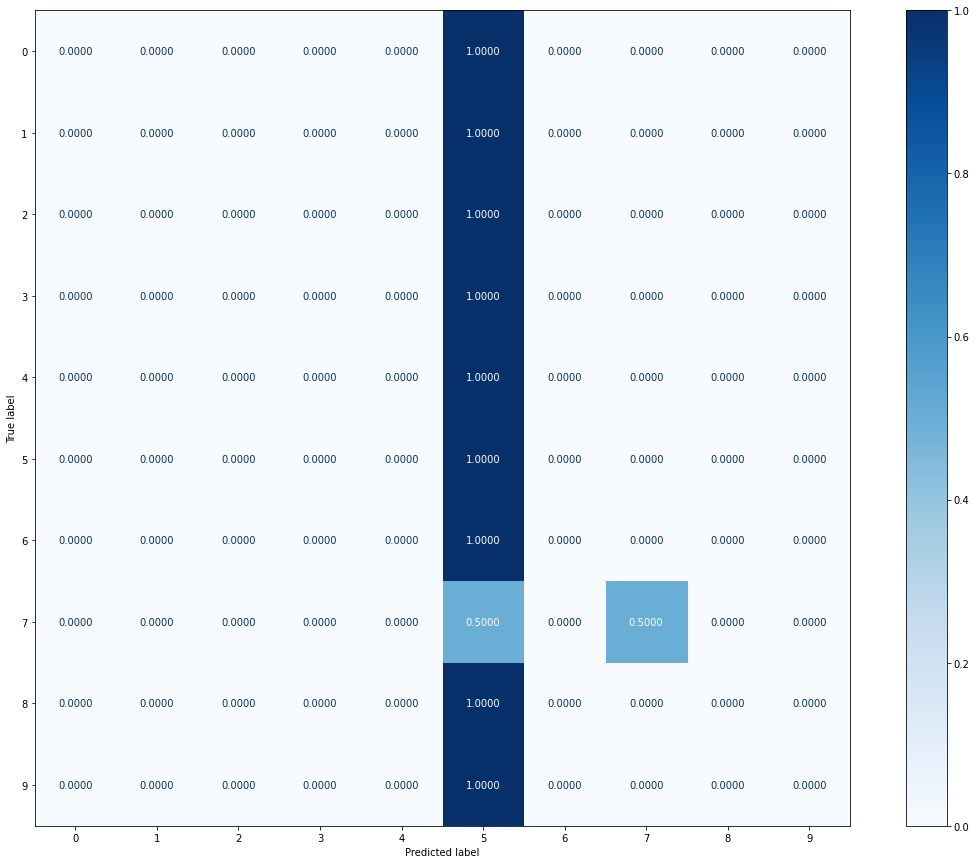

In [ ]:
from sklearn.metrics import plot_confusion_matrix
y_pred = clf.predict(X_test_pca)

_, axes = plt.subplots(1, 1, figsize=(20, 15))
disp = plot_confusion_matrix(clf, X_test_pca, y_test,
                            cmap=plt.cm.Blues,
                            normalize='true',
                            values_format='.4f',
                            ax=axes)
plt.show()


# 5- Conclusões

Podemos perceber que o algoritmo está enviesado, escolhendo sempre uma única classe na maioria das vezes, o que pode ser causado por um erro nas labels ou na qualidade das imagens de treino.
